In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import  RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from catboost import CatBoostClassifier
from sklearn import metrics

In [ ]:
file_path = '/content/mental_health_wearable_data.csv'
data2 = pd.read_csv(file_path)

In [ ]:
data2.head()

,Timestamp,EEG_Frequency_Bands,GSR_Values,Cognitive_State,Emotional_State,Student_ID,Age,Gender,Session_Type,Duration (minutes),Environmental_Context,Preprocessed_Features,Target
0,2025-01-01 10:00:00,"[7.400574384984986, 5.621240954745124, 4.62440...",1.376494,Distracted,Anxious,151,19,Female,Study,43,Library,"(0.09206977288455342, 0.3621872664986312)",0
1,2025-01-01 10:05:00,"[1.6898477932146672, 7.2616994947041125, 1.106...",0.084319,Focused,Stressed,150,20,Male,Test,49,Home,"(0.6630302454051626, 0.16534951688386967)",1
2,2025-01-01 10:10:00,"[0.2693319401287453, 8.909349692334239, 7.2444...",0.895629,Cognitive Overload,Anxious,173,24,Male,Test,56,Library,"(0.01057761975425231, 0.20044284523215694)",1
3,2025-01-01 10:15:00,"[6.080175212895389, 6.387554935291081, 9.09906...",0.386398,Focused,Anxious,171,22,Male,Relaxation,48,Library,"(0.2924924921884593, 0.8773068202243881)",1
4,2025-01-01 10:20:00,"[5.9007231710422525, 8.301537594579075, 4.4649...",1.186898,Focused,Anxious,131,22,Female,Relaxation,57,Home,"(0.7670629457831021, 0.5652674255918193)",0


In [ ]:
print("Shape:", data2.shape)

Shape: (500, 13)


In [ ]:
print("Columns:", list(data2.columns))

Columns: ['Timestamp', 'EEG_Frequency_Bands', 'GSR_Values', 'Cognitive_State', 'Emotional_State', 'Student_ID', 'Age', 'Gender', 'Session_Type', 'Duration (minutes)', 'Environmental_Context', 'Preprocessed_Features', 'Target']


In [ ]:
print("Duplicated rows:", data2.duplicated().sum())

Duplicated rows: 0


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              500 non-null    object 
 1   EEG_Frequency_Bands    500 non-null    object 
 2   GSR_Values             500 non-null    float64
 3   Cognitive_State        500 non-null    object 
 4   Emotional_State        500 non-null    object 
 5   Student_ID             500 non-null    int64  
 6   Age                    500 non-null    int64  
 7   Gender                 500 non-null    object 
 8   Session_Type           500 non-null    object 
 9   Duration (minutes)     500 non-null    int64  
 10  Environmental_Context  500 non-null    object 
 11  Preprocessed_Features  500 non-null    object 
 12  Target                 500 non-null    int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 50.9+ KB


In [ ]:
print(data2.count())

Timestamp                500
EEG_Frequency_Bands      500
GSR_Values               500
Cognitive_State          500
Emotional_State          500
Student_ID               500
Age                      500
Gender                   500
Session_Type             500
Duration (minutes)       500
Environmental_Context    500
Preprocessed_Features    500
Target                   500
dtype: int64


In [ ]:
data2 = data2.drop(data2.columns[0], axis=1)

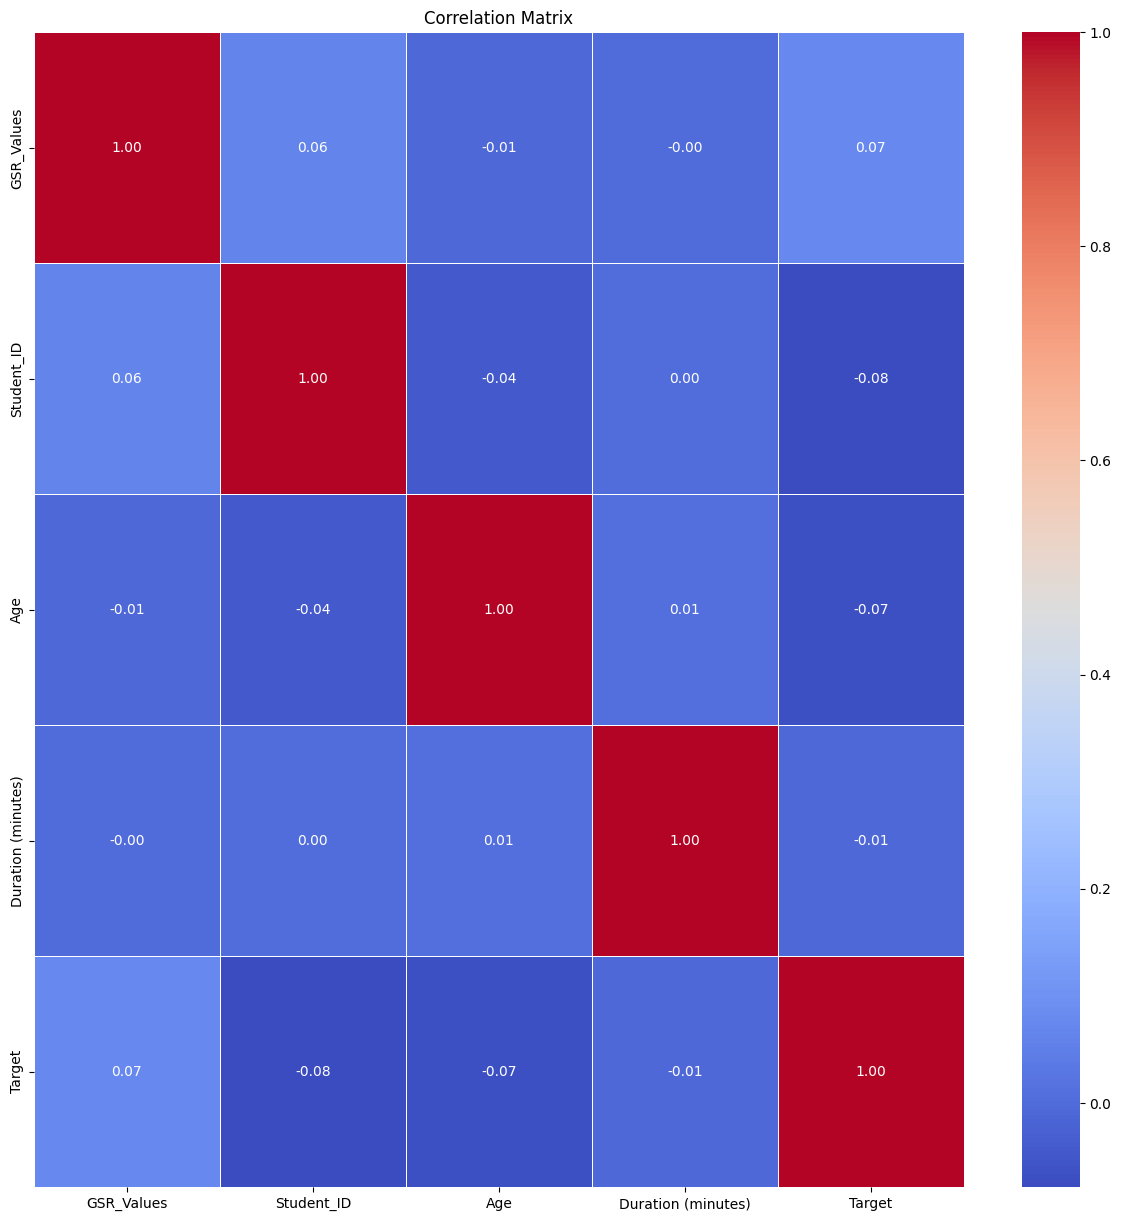

In [ ]:
plt.figure(figsize=(15, 15))
numeric_data = data2.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


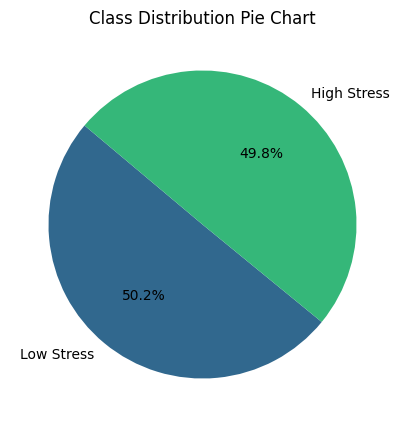

/tmp/ipython-input-12-402787501.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_labels, y=class_counts, palette='viridis')


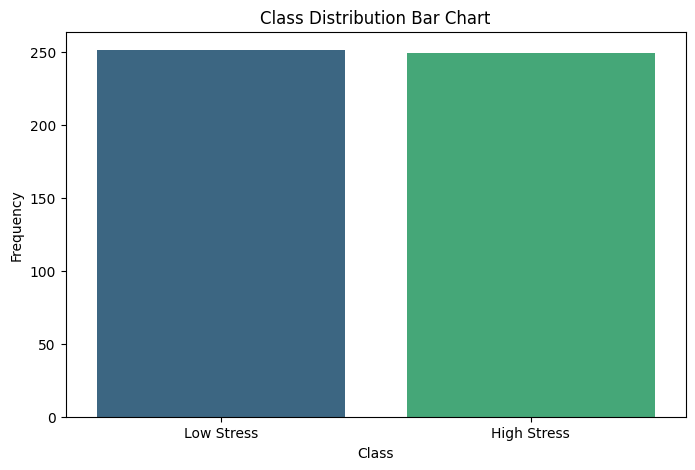

In [ ]:
# Calculate the count of each class in the 'target' column
class_counts = data2['Target'].value_counts()

# Create a dictionary to map the existing numeric labels to new descriptive labels for visualization
labels = {
    0: 'Low Stress',
    1: 'High Stress',

}
# Map the numeric labels to descriptive labels for plotting
new_labels = [labels[i] for i in class_counts.index]

# Pie Chart for class distribution
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=new_labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(class_counts)))
plt.title('Class Distribution Pie Chart')
plt.show()

# Bar Chart for class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=new_labels, y=class_counts, palette='viridis')
plt.title('Class Distribution Bar Chart')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
label_encoders = {}
for col in data2.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data2[col] = le.fit_transform(data2[col])
    label_encoders[col] = le


In [ ]:
# Creating holders to store the model performance results
ML_Model = []
ML_Config = []
accuracy = []
f1_score = []
recall = []
precision = []
auc_roc = []  # Adding a holder for AUC-ROC

# Function to call for storing the results
def storeResults(model,config, a, b, c, d, e):
    ML_Model.append(model)
    ML_Config.append(config)
    accuracy.append(round(a, 6))
    f1_score.append(round(b, 6))
    recall.append(round(c, 6))
    precision.append(round(d, 6))
    auc_roc.append(round(e, 6))

SVM

In [ ]:
X = data2.drop(columns=["Target"])  # Replace with correct target if needed
y = data2["Target"]

# Step 1: Split the dataset into training and test sets (before any preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuration list to store different data setups
configurations = []

# Configuration 1: Before any preprocessing (original data)
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Configuration 2: After Normalization
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3: Feature Selection and PCA after Normalization
# 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
scores = []
for k in range(1, X_train.shape[1] + 1):  # Loop through possible numbers of features
    kbest = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
    score = cross_val_score(SVC(kernel='linear'), X_train_kbest, y_train, cv=5, scoring='accuracy').mean()
    scores.append(score)

# Identify the optimal number of features
optimal_k = scores.index(max(scores)) + 1
print(f"Optimal number of features to select using SelectKBest: {optimal_k}")

# Apply SelectKBest with the optimal number of features
kbest = SelectKBest(score_func=f_classif, k=optimal_k)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)  # Apply the same transformation to X_test
selected_features_kbest = X.columns[kbest.get_support()]
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# 3.2: RFECV with SVM
print("\n=== RFECV Feature Selection with SVM ===")
svm_estimator = SVC(kernel='linear')  # Using a linear kernel for feature selection

rfecv = RFECV(estimator=svm_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_kbest, y_train)

print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")

# Perform RFE with the optimal number of features determined by RFECV
rfe = RFE(estimator=svm_estimator, n_features_to_select=rfecv.n_features_)
X_train_rfe = rfe.fit_transform(X_train_kbest, y_train)
X_test_rfe = rfe.transform(X_test_kbest)  # Apply the same transformation to X_test
selected_features_rfe = selected_features_kbest[rfe.get_support()]
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# 3.3: PCA for Dimensionality Reduction
print("\n=== PCA Dimensionality Reduction ===")

# Fit PCA on the RFE-transformed training data
pca = PCA().fit(X_train_rfe)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
desired_variance = 0.95
n_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f'Number of components that explain {desired_variance*100}% variance: {n_components}')

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca = pca.transform(X_test_rfe)  # Apply the same transformation to X_test
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Run SVM with Hyperparameter Tuning on different configurations
print("\n=== SVM Model Performance with Hyperparameter Tuning ===")

# Defining an expanded parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],                  # Regularization strength
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid'],          # Different kernel types
    'degree': [2, 3, 4],                           # Only used for 'poly' kernel
    'coef0': [0.0, 0.1, 0.5, 1.0]                  # Used in 'poly' and 'sigmoid'
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning SVM with {name} configuration...")
    svc = GridSearchCV(SVC(probability=True), param_grid, cv=3, n_jobs=-1, verbose=2)
    svc.fit(X_train_cfg, y_train_cfg)

    y_train_svc = svc.predict(X_train_cfg)
    y_test_svc = svc.predict(X_test_cfg)


    y_train_svc_proba = svc.predict_proba(X_train_cfg)
    y_test_svc_proba = svc.predict_proba(X_test_cfg)


    # Computing the metrics for the Support Vector Machine model
    metrics_dict = {
        "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_svc),
            metrics.accuracy_score(y_test, y_test_svc),
        ],
        "F1 Score": [
                   metrics.f1_score(y_train_cfg, y_train_svc, average='macro'),
                       metrics.f1_score(y_test, y_test_svc, average='macro'),
                    ],
        "Recall": [
                metrics.recall_score(y_train_cfg, y_train_svc, average='macro'),
                   metrics.recall_score(y_test, y_test_svc, average='macro'),
               ],
               "Precision": [
              metrics.precision_score(y_train_cfg, y_train_svc, average='macro'),
                     metrics.precision_score(y_test, y_test_svc, average='macro'),
                       ],
         "AUC-ROC": [
                   metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_svc_proba, multi_class='ovr', average='macro'),
                  metrics.roc_auc_score(pd.get_dummies(y_test), y_test_svc_proba, multi_class='ovr', average='macro'),
               ]

    }

    # Converting the metrics into a pandas DataFrame for better display
    df_metrics = pd.DataFrame(metrics_dict)

    # Display the metrics DataFrame
    print("\nSupport Vector Machine Model Performance Metrics")
    print(df_metrics.to_string(index=False))

    # Storing the results, now including the AUC-ROC score
    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_svc_proba, multi_class='ovr', average='macro')
    storeResults( 'Support Vector Machine',name,
               metrics.accuracy_score(y_test, y_test_svc),
               metrics.f1_score(y_test, y_test_svc, average='macro'),
               metrics.recall_score(y_test, y_test_svc, average='macro'),
               metrics.precision_score(y_test, y_test_svc, average='macro'),auc_score
               )

    # Print the best hyperparameters
    print("Best hyperparameters found by GridSearchCV:")
    print(svc.best_params_)


=== SelectKBest Feature Selection ===
Optimal number of features to select using SelectKBest: 5

=== RFECV Feature Selection with SVM ===
Optimal number of features selected by RFECV: 5

=== PCA Dimensionality Reduction ===
Number of components that explain 95.0% variance: 5

=== SVM Model Performance with Hyperparameter Tuning ===

Running SVM with Original Data configuration...
Fitting 3 folds for each of 900 candidates, totalling 2700 fits


Random Forest

In [ ]:
X = data2.drop(columns=["Target"])  # Replace with correct target if needed
y = data2["Target"]

# Step 1: Split the dataset into training and test sets (before any preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuration list to store different data setups
configurations = []

# Configuration 1: Before any preprocessing (original data)
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Configuration 2: After Normalization
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3: Feature Selection and PCA after Normalization
# 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
scores = []
for k in range(1, X_train.shape[1] + 1):  # Loop through possible numbers of features
    kbest = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
    score = cross_val_score(RandomForestClassifier(), X_train_kbest, y_train, cv=5, scoring='accuracy').mean()
    scores.append(score)

# Identify the optimal number of features
optimal_k = scores.index(max(scores)) + 1
print(f"Optimal number of features to select using SelectKBest: {optimal_k}")

# Apply SelectKBest with the optimal number of features
kbest = SelectKBest(score_func=f_classif, k=optimal_k)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)  # Apply the same transformation to X_test
selected_features_kbest = X.columns[kbest.get_support()]
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# 3.2: RFECV with RandomForestClassifier
print("\n=== RFECV Feature Selection with Random Forest ===")
rf_estimator = RandomForestClassifier()

rfecv = RFECV(estimator=rf_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_kbest, y_train)

print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")

# Perform RFE with the optimal number of features determined by RFECV
rfe = RFE(estimator=rf_estimator, n_features_to_select=rfecv.n_features_)
X_train_rfe = rfe.fit_transform(X_train_kbest, y_train)
X_test_rfe = rfe.transform(X_test_kbest)  # Apply the same transformation to X_test
selected_features_rfe = selected_features_kbest[rfe.get_support()]
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# 3.3: PCA for Dimensionality Reduction
print("\n=== PCA Dimensionality Reduction ===")

# Fit PCA on the RFE-transformed training data
pca = PCA().fit(X_train_rfe)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
desired_variance = 0.95
n_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f'Number of components that explain {desired_variance*100}% variance: {n_components}')

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca = pca.transform(X_test_rfe)  # Apply the same transformation to X_test
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Run RandomForestClassifier with Hyperparameter Tuning on different configurations
print("\n=== Random Forest Model Performance with Hyperparameter Tuning ===")

# Defining an expanded parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],             # More options for number of trees
    'max_depth': [10, 20, 30, 40, 60, None],              # Includes None for fully grown trees
    'min_samples_split': [2, 5, 10],                      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],                        # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2', None],               # Strategies for feature selection
    'bootstrap': [True, False],                           # Whether bootstrap samples are used
    'criterion': ['gini', 'entropy', 'log_loss']          # Includes all available criteria
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Random Forest with {name} configuration...")

    # GridSearchCV to find the best parameters for the RandomForestClassifier
    rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)  # 5-fold cross-validation

    # Fitting the model for grid search with the training data
    rf.fit(X_train_cfg, y_train_cfg)

    # Predicting the target values for the training and test sets
    y_train_rf = rf.predict(X_train_cfg)
    y_test_rf = rf.predict(X_test_cfg)


    # Computing the probability scores for AUC-ROC (for the positive class)
    y_train_rf_proba = rf.predict_proba(X_train_cfg) # Probability scores for the positive class
    y_test_rf_proba = rf.predict_proba(X_test_cfg)

    # Computing the metrics for the Random Forest model
    metrics_dict = {
        "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_rf),
            metrics.accuracy_score(y_test, y_test_rf),
        ],
        "F1 Score": [
                   metrics.f1_score(y_train_cfg, y_train_rf, average='macro'),
                       metrics.f1_score(y_test, y_test_rf, average='macro'),
                    ],
        "Recall": [
                metrics.recall_score(y_train_cfg, y_train_rf, average='macro'),
                   metrics.recall_score(y_test, y_test_rf, average='macro'),
               ],
               "Precision": [
              metrics.precision_score(y_train_cfg, y_train_rf, average='macro'),
                     metrics.precision_score(y_test, y_test_rf, average='macro'),
                       ],
         "AUC-ROC": [
                   metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_rf_proba, multi_class='ovr', average='macro'),
                  metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro'),
               ]

    }

    # Converting the metrics into a pandas DataFrame for better display
    df_metrics = pd.DataFrame(metrics_dict)

    # Display the metrics DataFrame
    print("\nRandom Forest Model Performance Metrics")
    print(df_metrics.to_string(index=False))
    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro')
    # Storing the results, now including the AUC-ROC score
    storeResults('Random Forest', name,
             metrics.accuracy_score(y_test, y_test_rf),
             metrics.f1_score(y_test, y_test_rf, average='macro'),
             metrics.recall_score(y_test, y_test_rf, average='macro'),
             metrics.precision_score(y_test, y_test_rf, average='macro'),
             auc_score)

# Print the best hyperparameters
print("Best hyperparameters found by GridSearchCV:")
print(rf.best_params_)


Gradient Boosting

In [ ]:
X = data2.drop(columns=["Target"])  # Replace with correct target if needed
y = data2["Target"]
# Step 1: Split the dataset into training and test sets (before any preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuration list to store different data setups
configurations = []

# Configuration 1: Before any preprocessing (original data)
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Configuration 2: After Normalization
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3: Feature Selection and PCA after Normalization
# 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
scores = []
for k in range(1, X_train.shape[1] + 1):  # Loop through possible numbers of features
    kbest = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
    score = cross_val_score(GradientBoostingClassifier(), X_train_kbest, y_train, cv=5, scoring='accuracy').mean()
    scores.append(score)

# Identify the optimal number of features
optimal_k = scores.index(max(scores)) + 1
print(f"Optimal number of features to select using SelectKBest: {optimal_k}")

# Apply SelectKBest with the optimal number of features
kbest = SelectKBest(score_func=f_classif, k=optimal_k)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)  # Apply the same transformation to X_test
selected_features_kbest = X.columns[kbest.get_support()]
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# 3.2: RFECV with GradientBoostingClassifier
print("\n=== RFECV Feature Selection with Gradient Boosting ===")
gbc_estimator = GradientBoostingClassifier()

rfecv = RFECV(estimator=gbc_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_kbest, y_train)

print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")

# Perform RFE with the optimal number of features determined by RFECV
rfe = RFE(estimator=gbc_estimator, n_features_to_select=rfecv.n_features_)
X_train_rfe = rfe.fit_transform(X_train_kbest, y_train)
X_test_rfe = rfe.transform(X_test_kbest)  # Apply the same transformation to X_test
selected_features_rfe = selected_features_kbest[rfe.get_support()]
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# 3.3: PCA for Dimensionality Reduction
print("\n=== PCA Dimensionality Reduction ===")

# Fit PCA on the RFE-transformed training data
pca = PCA().fit(X_train_rfe)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
desired_variance = 0.95
n_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f'Number of components that explain {desired_variance*100}% variance: {n_components}')

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca = pca.transform(X_test_rfe)  # Apply the same transformation to X_test
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Run GradientBoostingClassifier with Hyperparameter Tuning on different configurations
print("\n=== Gradient Boosting Model Performance with Hyperparameter Tuning ===")

# Defining a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],         # Learning rate shrinkage
    'n_estimators': [100, 200, 300, 400, 500],       # Number of boosting stages
    'max_depth': [3, 4, 5, 6, 7],                    # Maximum depth of individual estimators
    'min_samples_split': [2, 5, 10],                 # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],                   # Minimum samples at a leaf node
    'subsample': [0.6, 0.8, 1.0],                    # Fraction of samples used for fitting
    'max_features': ['sqrt', 'log2', None]           # Features considered at each split
}
for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Gradient Boosting with {name} configuration...")

    # GridSearchCV to find the best parameters for the GradientBoostingClassifier
    gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)

    # Fitting the model for grid search with the training data
    gbc.fit(X_train_cfg, y_train_cfg)

    # Predicting the target values for the training and test sets
    y_train_gbc = gbc.predict(X_train_cfg)
    y_test_gbc = gbc.predict(X_test_cfg)

    # Computing the probability scores for AUC-ROC (for the positive class)
    y_train_gbc_proba = gbc.predict_proba(X_train_cfg) # Probability scores for the positive class
    y_test_gbc_proba = gbc.predict_proba(X_test_cfg)
    # Computing the metrics for the Gradient Boosting model
    metrics_dict = {
        "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_gbc),
            metrics.accuracy_score(y_test, y_test_gbc),
        ],
        "F1 Score": [
            metrics.f1_score(y_train_cfg, y_train_gbc, average='macro'),
            metrics.f1_score(y_test, y_test_gbc, average='macro'),
        ],
        "Recall": [
            metrics.recall_score(y_train_cfg, y_train_gbc, average='macro'),
            metrics.recall_score(y_test, y_test_gbc, average='macro'),
        ],
        "Precision": [
            metrics.precision_score(y_train_cfg, y_train_gbc, average='macro'),
            metrics.precision_score(y_test, y_test_gbc, average='macro'),
        ],
        "AUC-ROC": [
            metrics.roc_auc_score(pd.get_dummies(y_train_cfg), gbc.predict_proba(X_train_cfg), multi_class='ovr', average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), gbc.predict_proba(X_test_cfg), multi_class='ovr', average='macro'),

        ]
    }

    # Converting the metrics into a pandas DataFrame for better display
    df_metrics = pd.DataFrame(metrics_dict)

    # Display the metrics DataFrame
    print("\nGradient Boosting Model Performance Metrics")
    print(df_metrics.to_string(index=False))
    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro')
    # Storing the results, now including the AUC-ROC score
    storeResults('Gradient Boosting',
                 name,
                 metrics.accuracy_score(y_test, y_test_gbc),
                 metrics.f1_score(y_test, y_test_gbc,average='macro'),
                 metrics.recall_score(y_test, y_test_gbc,average='macro'),
                 metrics.precision_score(y_test, y_test_gbc,average='macro'),
                 auc_score
                 )

    # Print the best hyperparameters
    print("Best hyperparameters found by GridSearchCV:")
    print(gbc.best_params_)

Cat Bosting

In [ ]:
X = data2.drop(columns=["Target"])  # Replace with correct target if needed
y = data2["Target"]
# Step 1: Split the dataset into training and test sets (before any preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuration list to store different data setups
configurations = []

# Configuration 1: Before any preprocessing (original data)
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Configuration 2: After Normalization
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3: Feature Selection and PCA after Normalization
# 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
scores = []
for k in range(1, X_train.shape[1] + 1):  # Loop through possible numbers of features
    kbest = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
    score = cross_val_score(CatBoostClassifier(silent=True), X_train_kbest, y_train, cv=5, scoring='accuracy').mean()
    scores.append(score)

# Identify the optimal number of features
optimal_k = scores.index(max(scores)) + 1
print(f"Optimal number of features to select using SelectKBest: {optimal_k}")

# Apply SelectKBest with the optimal number of features
kbest = SelectKBest(score_func=f_classif, k=optimal_k)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)  # Apply the same transformation to X_test
selected_features_kbest = X.columns[kbest.get_support()]
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# 3.2: RFECV with CatBoostClassifier
print("\n=== RFECV Feature Selection with CatBoost ===")
cat_estimator = CatBoostClassifier(silent=True)

rfecv = RFECV(estimator=cat_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_kbest, y_train)

print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")

# Perform RFE with the optimal number of features determined by RFECV
rfe = RFE(estimator=cat_estimator, n_features_to_select=rfecv.n_features_)
X_train_rfe = rfe.fit_transform(X_train_kbest, y_train)
X_test_rfe = rfe.transform(X_test_kbest)  # Apply the same transformation to X_test
selected_features_rfe = selected_features_kbest[rfe.get_support()]
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# 3.3: PCA for Dimensionality Reduction
print("\n=== PCA Dimensionality Reduction ===")

# Fit PCA on the RFE-transformed training data
pca = PCA().fit(X_train_rfe)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
desired_variance = 0.95
n_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f'Number of components that explain {desired_variance*100}% variance: {n_components}')

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca = pca.transform(X_test_rfe)  # Apply the same transformation to X_test
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Run CatBoostClassifier with Hyperparameter Tuning on different configurations
print("\n=== CatBoost Model Performance with Hyperparameter Tuning ===")

# Defining a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.1],
    'depth': [6, 8, 10],
    'iterations': [200, 300, 400]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning CatBoost with {name} configuration...")

    # GridSearchCV to find the best parameters for the CatBoostClassifier
    cat = GridSearchCV(CatBoostClassifier(silent=True), param_grid, cv=5)

    # Fitting the model for grid search with the training data
    cat.fit(X_train_cfg, y_train_cfg)

    # Predicting the target values for the training and test sets
    y_train_cat = cat.predict(X_train_cfg)
    y_test_cat = cat.predict(X_test_cfg)

    # Computing the probability scores for AUC-ROC (for the positive class)
    y_train_cat_proba = cat.predict_proba(X_train_cfg) # Probability scores for the positive class
    y_test_cat_proba = cat.predict_proba(X_test_cfg)
    # Computing the metrics for the CatBoost model
    metrics_dict = {
        "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_cat),
            metrics.accuracy_score(y_test, y_test_cat),
        ],
        "F1 Score": [
            metrics.f1_score(y_train_cfg, y_train_cat),
            metrics.f1_score(y_test, y_test_cat),
        ],
        "Recall": [
            metrics.recall_score(y_train_cfg, y_train_cat),
            metrics.recall_score(y_test, y_test_cat),
        ],
        "Precision": [
            metrics.precision_score(y_train_cfg, y_train_cat),
            metrics.precision_score(y_test, y_test_cat),
        ],
        "AUC-ROC": [
            metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_cat_proba, multi_class='ovr', average='macro'),
            metrics.roc_auc_score(pd.get_dummies(y_test), y_test_cat_proba, multi_class='ovr', average='macro'),
        ]
    }

    # Converting the metrics into a pandas DataFrame for better display
    df_metrics = pd.DataFrame(metrics_dict)

    # Display the metrics DataFrame
    print("\nCatBoost Model Performance Metrics")
    print(df_metrics.to_string(index=False))
    #auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro')
    # Storing the results, now including the AUC-ROC score
    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_cat_proba, multi_class='ovr', average='macro')
    storeResults('CatBoost',
                 name,
                 metrics.accuracy_score(y_test, y_test_cat),
                 metrics.f1_score(y_test, y_test_cat, average='macro'),
                 metrics.recall_score(y_test, y_test_cat, average='macro'),
                 metrics.precision_score(y_test, y_test_cat, average='macro'),
                 auc_score

                )

    # Print the best hyperparameters
    print("Best hyperparameters found by GridSearchCV:")
    print(cat.best_params_)

XGBoost

In [ ]:
# Assuming X and y are your features and labels
X = data2.drop(columns=["Target"])  # Replace with correct target if needed
y = data2["Target"]
# Step 1: Split the dataset into training and test sets (before any preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuration list to store different data setups
configurations = []

# Configuration 1: Before any preprocessing (original data)
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Configuration 2: After Normalization
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3: Feature Selection and PCA after Normalization
# 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
scores = []
for k in range(1, X_train.shape[1] + 1):  # Loop through possible numbers of features
    kbest = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
    score = cross_val_score(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X_train_kbest, y_train, cv=5, scoring='accuracy').mean()
    scores.append(score)

# Identify the optimal number of features
optimal_k = scores.index(max(scores)) + 1
print(f"Optimal number of features to select using SelectKBest: {optimal_k}")

# Apply SelectKBest with the optimal number of features
kbest = SelectKBest(score_func=f_classif, k=optimal_k)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)  # Apply the same transformation to X_test
selected_features_kbest = X.columns[kbest.get_support()]
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# 3.2: RFECV with XGBoost
print("\n=== RFECV Feature Selection with XGBoost ===")
xgb_estimator = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

rfecv = RFECV(estimator=xgb_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_kbest, y_train)

print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")

# Perform RFE with the optimal number of features determined by RFECV
rfe = RFE(estimator=xgb_estimator, n_features_to_select=rfecv.n_features_)
X_train_rfe = rfe.fit_transform(X_train_kbest, y_train)
X_test_rfe = rfe.transform(X_test_kbest)  # Apply the same transformation to X_test
selected_features_rfe = selected_features_kbest[rfe.get_support()]
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# 3.3: PCA for Dimensionality Reduction
print("\n=== PCA Dimensionality Reduction ===")

# Fit PCA on the RFE-transformed training data
pca = PCA().fit(X_train_rfe)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
desired_variance = 0.95
n_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f'Number of components that explain {desired_variance*100}% variance: {n_components}')

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca = pca.transform(X_test_rfe)  # Apply the same transformation to X_test
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Run XGBoost with Hyperparameter Tuning on different configurations
print("\n=== XGBoost Model Performance with Hyperparameter Tuning ===")

# Defining a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning XGBoost with {name} configuration...")

    # GridSearchCV to find the best parameters for the XGBoost model
    xgbm = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5)

    # Fitting the model for grid search with the training data
    xgbm.fit(X_train_cfg, y_train_cfg)

    # Predicting the target values for the training and test sets
    y_train_xgbm = xgbm.predict(X_train_cfg)
    y_test_xgbm = xgbm.predict(X_test_cfg)

    # Computing the probability scores for AUC-ROC (for the positive class)
    y_train_xgbm_proba = xgbm.predict_proba(X_train_cfg)[:, 1]  # Probability scores for the positive class
    y_test_xgbm_proba = xgbm.predict_proba(X_test_cfg)[:, 1]

    # Computing the metrics for the XGBoost model
    metrics_dict = {
       "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_xgbm),
            metrics.accuracy_score(y_test, y_test_xgbm),
        ],
        "F1 Score": [
            metrics.f1_score(y_train_cfg, y_train_xgbm),
            metrics.f1_score(y_test, y_test_xgbm),
        ],
        "Recall": [
            metrics.recall_score(y_train_cfg, y_train_xgbm),
            metrics.recall_score(y_test, y_test_xgbm),
        ],
        "Precision": [
            metrics.precision_score(y_train_cfg, y_train_xgbm),
            metrics.precision_score(y_test, y_test_xgbm),
        ],
        "AUC-ROC": [
            metrics.roc_auc_score(y_train_cfg, y_train_xgbm_proba),
            metrics.roc_auc_score(y_test, y_test_xgbm_proba),
        ]
    }

    # Converting the metrics into a pandas DataFrame for better display
    df_metrics = pd.DataFrame(metrics_dict)

    # Display the metrics DataFrame
    print("\nXGBoost Model Performance Metrics")
    print(df_metrics.to_string(index=False))

    # Storing the results, now including the AUC-ROC score
    storeResults('XGBoost',
                 name,
                 metrics.accuracy_score(y_test, y_test_xgbm),
                 metrics.f1_score(y_test, y_test_xgbm, average='macro'),
                 metrics.recall_score(y_test, y_test_xgbm, average='macro'),
                 metrics.precision_score(y_test, y_test_xgbm, average='macro'),
                 metrics.roc_auc_score(y_test, y_test_xgbm_proba, average='macro'))

    # Print the best hyperparameters
    print("Best hyperparameters found by GridSearchCV:")
    print(xgbm.best_params_)

In [ ]:
# Creating the dataframe
result = pd.DataFrame({
    'ML Model' : ML_Model,
    'Configuration': ML_Config,
    'Accuracy' : [f"{acc * 100:.3f}%" for acc in accuracy],
    'F1 Score' : [f"{f1 * 100:.3f}%" for f1 in f1_score],
    'Recall'   : [f"{rec * 100:.3f}%" for rec in recall],
    'Precision': [f"{prec * 100:.3f}%" for prec in precision],
    'ROC_AUC'  : [f"{roc * 100:.3f}%" for roc in auc_roc],
})

# Displaying the result
result.drop_duplicates(subset=["ML Model", "Configuration"], inplace=True)
print(result)

# Saving the result to a CSV file
result.to_csv('model_results6.csv', index=False)

# Sorting the dataframe on accuracy and F1 Score
sorted_result = result.sort_values(by=['Accuracy', 'F1 Score'], ascending=False).reset_index(drop=True)

# Displaying the sorted result
print(sorted_result)

# Saving the sorted result to a CSV file
sorted_result.to_csv('sorted_model_results6.csv', index=False)